# **Application of Computer Vision on Road Data**

# Dataset & Problem Description

Self-driving cars need to be able to identify common entities on or alongside the road. The dataset "Udacity Self-Driving Car" on Roboflow provides 15000 images containing pedestrians, cars, traffic lights, bikers, etc and labels containing the coordinates for those objects. The objective of this vignettte is to train a computer vision model on the images in order to associate the labels with the correct objects. The vignette uses the YOLOv7 model to detect the different potential roadside objects and labels the objects along with the probability that the object is what it's labeled as.

## Why YOLOv7?

The YOLOv7 model was chosen as some members of the project group had prior experience with the model on PyTorch.



# Basic Setup

1.   Clone the YOLOv7 repository
2.   Load Pretrained Model
3.   Download Dataset
4.   Split test/train
5.   Sample Labeling on a image



In [ ]:
# Installing PYTorch and connecting it to a GPU from a server PC
!pip install "torch<2.6" "torchvision<0.21"
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

### YOLO V7 Repository Clone

In [ ]:
# Monitors the status of the GPU.
!nvidia-smi

# 1) Clone YOLOv7 repo
!git clone https://github.com/WongKinYiu/yolov7.git
%cd yolov7

# 2) Install requirements
!sed -i '/numpy/d' requirements.txt
!grep -i numpy requirements.txt

!pip install --upgrade pip
!pip install -r requirements.txt

### Pre Trained Model YOLOv7

The advantage of using a pre-trained YOLOv7 model  is the amount of time saved from having pre-determined weights that can be fine-tuned to apply to detecting cars, pedestrians, etc. versus determining the weights from scratch.



**Base YOLOv7 weights**

```
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt
```




In [ ]:
# Change directory to the YOLOv7 Model
%cd /content/yolov7

# Download base YOLOv7 weights
# !wget -nc https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt
!wget -nc https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt

!ls -lh yolov7*.pt

### Manual Dataset Download

https://public.roboflow.com/object-detection/self-driving-car

In [ ]:
# ===== Shenyi: Manual upload & extract YOLOv7 dataset =====

import os
from google.colab import files
import zipfile

# Upload the YOLOv7 dataset zip
uploaded = files.upload()

# Get file name
zip_name = next(iter(uploaded))
print("Uploaded zip:", zip_name)

# Extract to /content/data/yolov7
extract_dir = "/content/data/yolov7"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_name, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

# List directory to verify st

print("Extracted to:", extract_dir)





In [ ]:
# ===== Split export/ into train/ and valid/ (Shenyi) =====
from pathlib import Path
import random
import shutil
import os

export_root = Path("/content/data/yolov7/export")
images_dir = export_root / "images"
labels_dir = export_root / "labels"

# Check if the image and label directories exist
print("Images dir exists:", images_dir.exists())
print("Labels dir exists:", labels_dir.exists())

# 1. collect images
image_files = sorted(list(images_dir.glob("*.jpg")) + list(images_dir.glob("*.png")))
print("Total images:", len(image_files))

# 2. split 80/20
random.seed(42)
random.shuffle(image_files)

# Determining the ending index for the training images
train_ratio = 0.8
n_train = int(len(image_files) * train_ratio)

train_files = image_files[:n_train]
val_files   = image_files[n_train:]

print(f"Train images: {len(train_files)}")
print(f"Valid images: {len(val_files)}")

# 3. create folders
root = Path("/content/data/yolov7")
for split in ["train", "valid"]:
    for sub in ["images", "labels"]:
        (root / split / sub).mkdir(parents=True, exist_ok=True)

def copy_pair(img_path, split):
    """Copy image + label into train/ or valid/ folders."""
    dst_img = root / split / "images" / img_path.name
    shutil.copy2(img_path, dst_img)

    label_src = labels_dir / (img_path.stem + ".txt")
    if label_src.exists():
        dst_label = root / split / "labels" / label_src.name
        shutil.copy2(label_src, dst_label)

# 4. copy
for img in train_files:
    copy_pair(img, "train")

for img in val_files:
    copy_pair(img, "valid")

print("Done splitting dataset.")

# 5. check folders
!ls -R /content/data/yolov7


### Auto Dataset Download

https://public.roboflow.com/object-detection/self-driving-car

In [ ]:
# Changing directory to the content folder and installing RoboFlow package via
# pip
%cd /content
!pip install roboflow

from google.colab import userdata
from roboflow import Roboflow

# Inputting RoboFlow API Key (found on RoboFlow) and then finding the dataset
# and downloading it
ROBOFLOW_API_KEY = "insert_api_key_here" # Key is blank for security purposes
if ROBOFLOW_API_KEY is None:
    raise ValueError("RoboflowApi is not set in Colab user data")

rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
version = project.version(3)

dataset = version.download("yolov7", location="data/yolov7")
print("Dataset location:", dataset.location)



### Dataset (Training/Validation/Testing split)

In [ ]:
# ===== Split export/ into train/ and valid/ =====
from pathlib import Path
import random
import shutil

export_root = Path("data/yolov7/export")
images_dir = export_root / "images"
labels_dir = export_root / "labels"

# Check if the image and label directories exist

print("Images dir exists:", images_dir.exists())
print("Labels dir exists:", labels_dir.exists())

# Sorts the images and searches for images that are in either jpg or png formats.
image_files = sorted(list(images_dir.glob("*.jpg")) + list(images_dir.glob("*.png")))
print("Total images:", len(image_files))

random.seed(42)
random.shuffle(image_files)

# Maintaining 80/20 ratio of training to validation images. Extra 5% of images for
# testing.
train_ratio = 0.20
val_ratio = 0.05
test_ratio = 0.05

n_train = int(len(image_files) * train_ratio)
n_val = int(len(image_files) * val_ratio)
n_test = int(len(image_files) * test_ratio)

train_files = image_files[:n_train]
val_files   = image_files[n_train : n_train + n_val]
test_files  = image_files[n_train + n_val : n_train + n_val + n_test]

print(f"Train images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")
print(f"Test images: {len(test_files)}")

# data/yolov7/train|valid|test/{images,labels}
root = Path("data/yolov7")
for split in ["train", "valid", "test"]:
    for sub in ["images", "labels"]:
        # Clear existing directories before recreating
        shutil.rmtree(root / split / sub, ignore_errors=True)
        (root / split / sub).mkdir(parents=True, exist_ok=True)

# Copy images into recreated images and labels folders
def copy_pair(img_path: Path, split: str):
    """Copy image and its label (if it exists) into train/ or valid/."""
    dst_img = root / split / "images" / img_path.name
    shutil.copy2(img_path, dst_img)

    label_src = labels_dir / (img_path.stem + ".txt")
    if label_src.exists():
        dst_label = root / split / "labels" / label_src.name
        shutil.copy2(label_src, dst_label)

for img in train_files:
    copy_pair(img, "train")

for img in val_files:
    copy_pair(img, "valid")

for img in test_files:
    copy_pair(img, "test")

print("Done splitting dataset.")

Images dir exists: True
Labels dir exists: True
Total images: 29800
Train images: 5960
Validation images: 1490
Done splitting dataset.


YOLOv7 uses the classes of road-side objects below to train the model on what an object in the given image can be classified as.

In [ ]:
# Changing directory to YOLOv7
%cd /content/yolov7

# Constructing yaml file that indicates where the images are located and the
# categories of objects that can be encountered in the images.
data_yaml = """
train: /content/data/yolov7/train/images
val: /content/data/yolov7/valid/images
test: /content/data/yolov7/test/images

nc: 11
names:
  - biker
  - car
  - pedestrian
  - trafficLight
  - trafficLight-Green
  - trafficLight-GreenLeft
  - trafficLight-Red
  - trafficLight-RedLeft
  - trafficLight-Yellow
  - trafficLight-YellowLeft
  - truck
"""

with open("self_driving_data.yaml", "w") as f:
    f.write(data_yaml)

print("Wrote config to /content/yolov7/self_driving_data.yaml")

/content/yolov7
Wrote config to /content/yolov7/self_driving_data.yaml


### Sample Labeling

In [ ]:
import yaml
# Loading data_yaml and defining the class names
data_config = yaml.safe_load(data_yaml)
names = data_config['names']
train_images_dir = Path("/content/data/yolov7/train/images")

print("Class names:", names)

Class names: ['biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck']


Number of train images found: 5960
Showing: /content/data/yolov7/train/images/1478020599702483565_jpg.rf.b68489919ee5957bc8e23d19b6c671aa.jpg


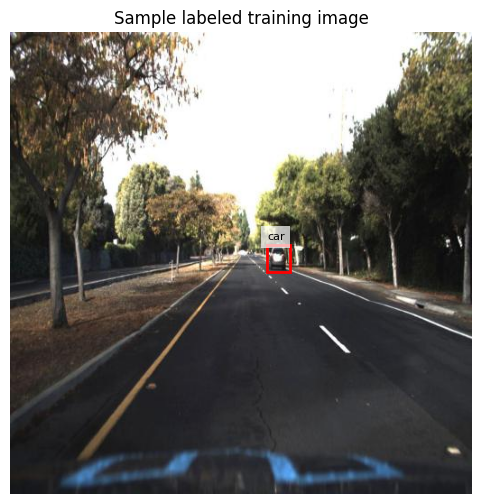

In [ ]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Labels an image from its image path.
def load_image_and_labels(img_path: Path):
    label_path = Path(str(img_path).replace("images", "labels")).with_suffix(".txt")
    boxes = []
    if label_path.exists():
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                cls_id = int(parts[0])
                x_c, y_c, w, h = map(float, parts[1:])
                boxes.append((cls_id, x_c, y_c, w, h))
    return Image.open(img_path).convert("RGB"), boxes

# Plots the label box on the object in the image
def plot_one_labeled_image(img_path: Path, class_names):
    img, boxes = load_image_and_labels(img_path)
    W, H = img.size

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img)

    for cls_id, x_c, y_c, w, h in boxes:
        x_c *= W; y_c *= H
        w *= W;  h *= H
        x0 = x_c - w / 2
        y0 = y_c - h / 2

        rect = patches.Rectangle(
            (x0, y0),
            w, h,
            linewidth=2,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

        label = class_names[cls_id]
        ax.text(
            x0, max(y0 - 5, 0),
            label,
            fontsize=8,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        )

    ax.axis("off")
    plt.title("Sample labeled training image")
    plt.show()

# Lists all the training images
train_images = list(train_images_dir.glob("*.jpg")) + list(train_images_dir.glob("*.png"))
print("Number of train images found:", len(train_images))

# Take a random image from the set of training images and plot a label on the
# detected object from the class of potential road-side objects.
sample_img = random.choice(train_images)
print("Showing:", sample_img)
plot_one_labeled_image(sample_img, names)

data/yolov7/data.yaml

```
names:
- biker
- car
- pedestrian
- trafficLight
- trafficLight-Green
- trafficLight-GreenLeft
- trafficLight-Red
- trafficLight-RedLeft
- trafficLight-Yellow
- trafficLight-YellowLeft
- truck
nc: 11
train: /content/data/yolov7/train/images
val: /content/data/yolov7/valid/images
```



# Fine-tuning YOLOv7-Tiny on the Self-Driving Car Dataset


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
# Loads the weights onto the image-training python file.
# Ultimately builds the training model with weights that can be applied to images
# in the self-driving car data set.
%cd /content/yolov7
!grep -n "torch.load(weights, map_location=device)" train.py
!sed -i "s/torch.load(weights, map_location=device)/torch.load(weights, map_location=device, weights_only=False)/g" train.py
!grep -n "torch.load(weights" train.py


# Experiment 1


In [ ]:
# Changing directory to YOLOv7
%cd /content/yolov7

EXP_NAME = "car-vision-yolov7-finetune"

# Runs the training model on a subset of the images, where the self_driving_data
# yaml contains the different classifications of objects (cars, traffic lights,
# pedestrians, etc.)
# The results of the experiment are assigned to the object EXP_name.

!python train.py \
  --img 512 \
  --batch 4 \
  --epochs 5 \
  --data /content/yolov7/self_driving_data.yaml \
  --cfg cfg/training/yolov7-tiny.yaml \
  --weights yolov7-tiny.pt \
  --name {EXP_NAME}


## Evaluation of the Training Data


### Objectives

*   Show metrics such as Mean Average Precision (mAP), precision, recall etc.
*   Show F1 Curve (relationship between confidence threshold and F1 Score) and Confusion matrix (relationship between predicted and actual classification of the Object). <br>

    * Note: The F1 Score is the harmonic mean of the precision and recall metrics.



--- Training Metrics (car-vision-yolov7-finetune) ---
       0/4    0.218G   0.06749  0.009839   0.01568   0.09301        28       512    0.4677    0.1856    0.1187    0.0413   0.08365   0.02043   0.02229
       1/4    0.562G   0.05175  0.009165  0.009161   0.07007        23       512    0.6391    0.2219    0.1938   0.07993    0.0708   0.02323   0.01855
       2/4    0.661G   0.04772  0.008976  0.007336   0.06403        86       512    0.4113    0.2403    0.2099   0.08657   0.07219   0.02227   0.01716
       3/4    0.661G   0.04437  0.008801   0.00622   0.05939         5       512    0.4592    0.3059    0.2511    0.1105   0.06844   0.02288   0.01616
       4/4    0.661G   0.04324  0.008666  0.005979   0.05788         7       512    0.5194    0.2806    0.2712    0.1206   0.06693   0.02313   0.01501


--- Training Results Plot (car-vision-yolov7-finetune) ---


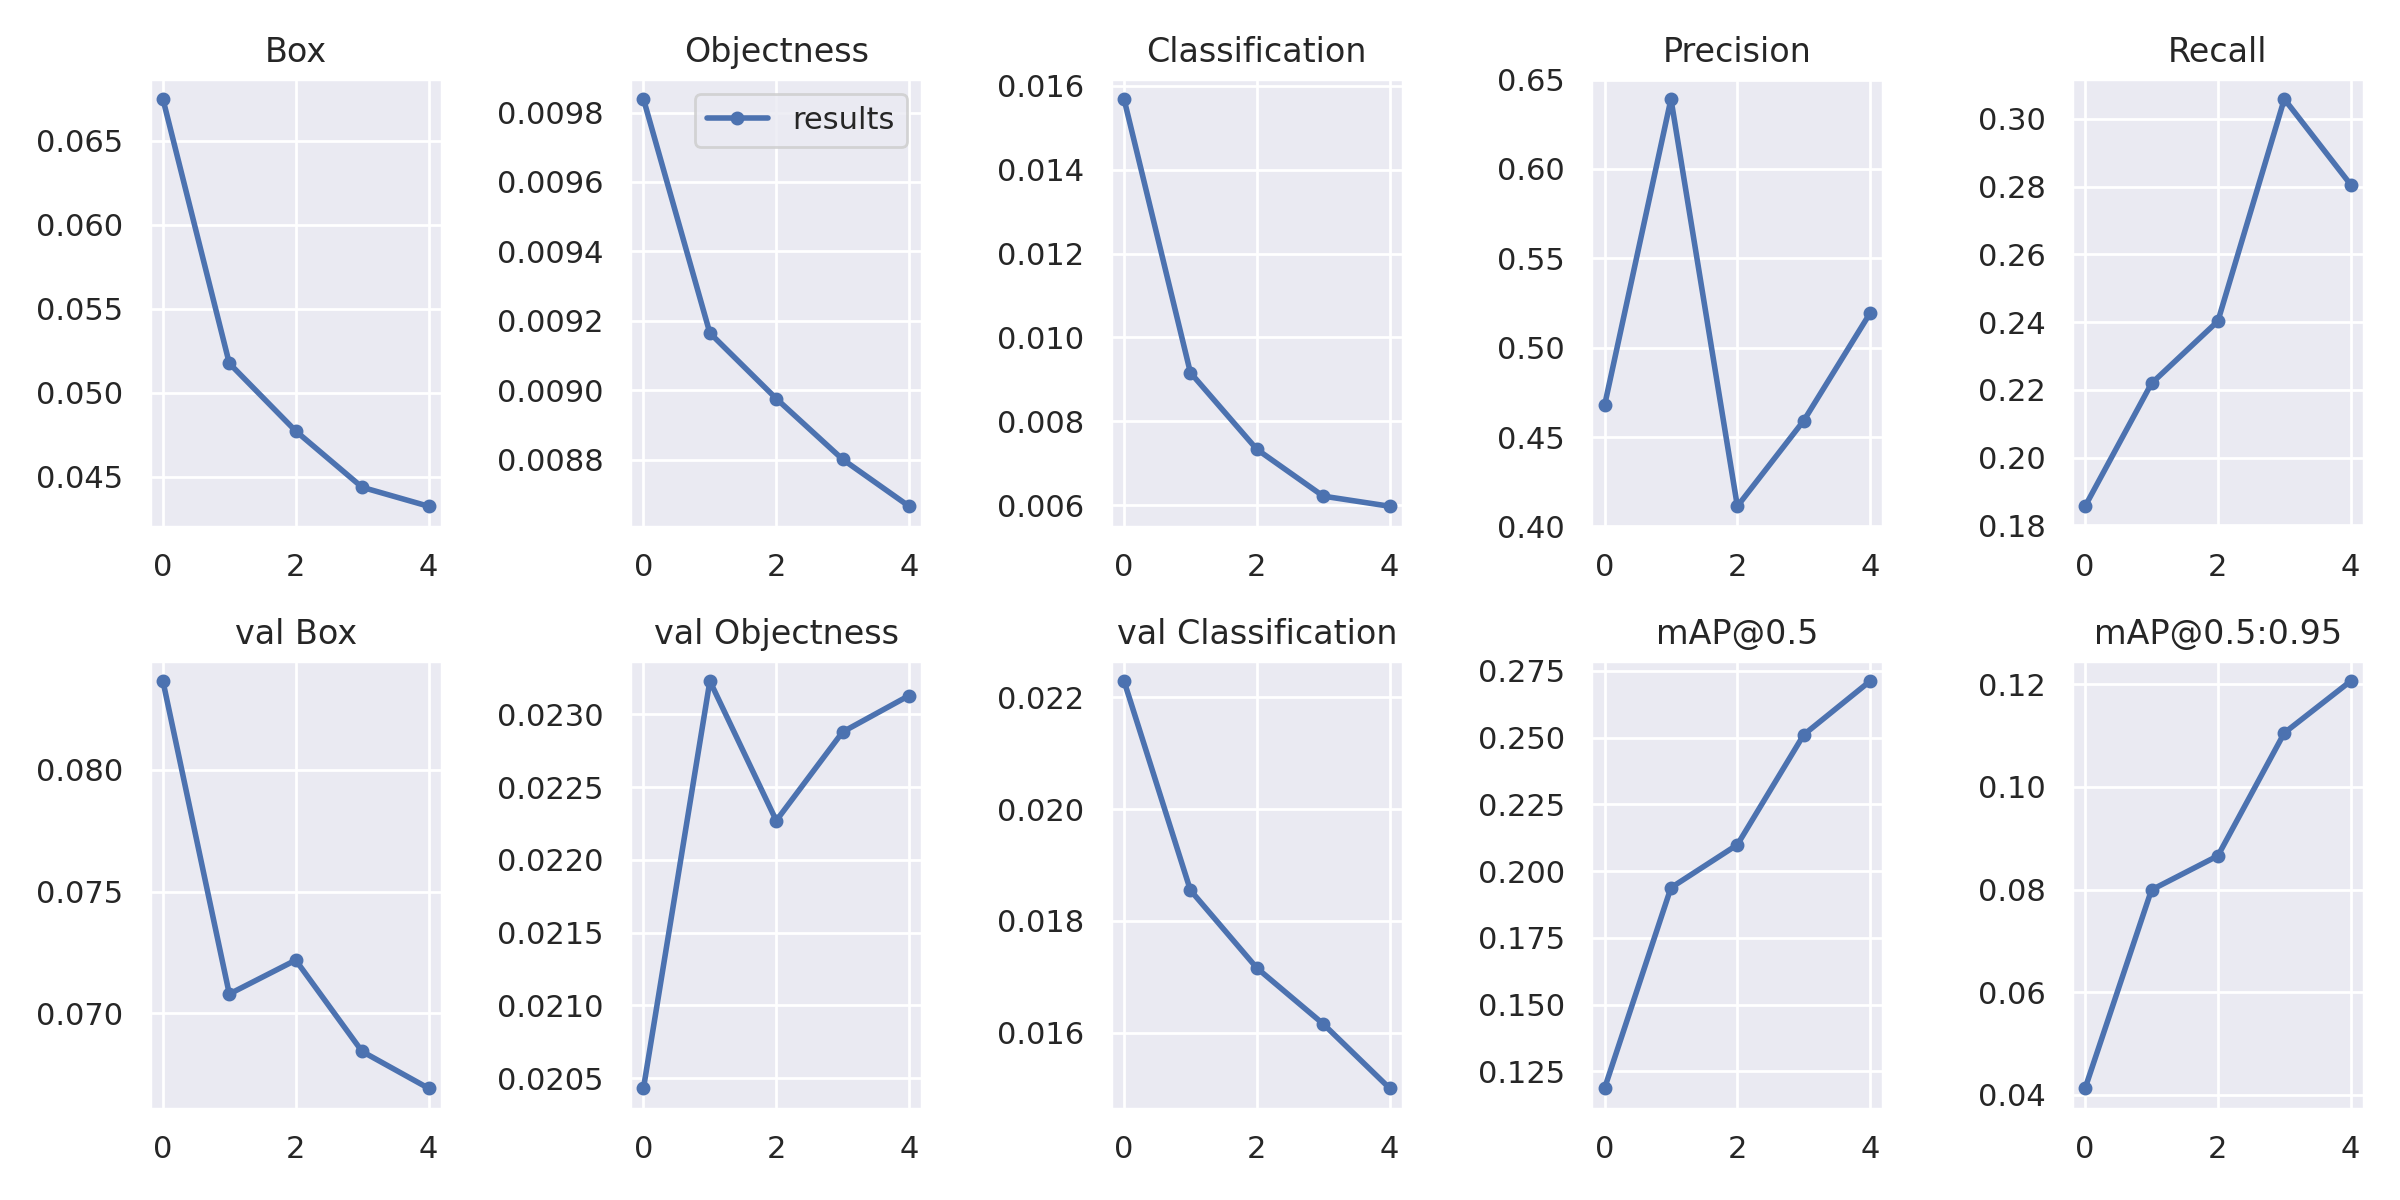


--- Confusion Matrix (car-vision-yolov7-finetune) ---


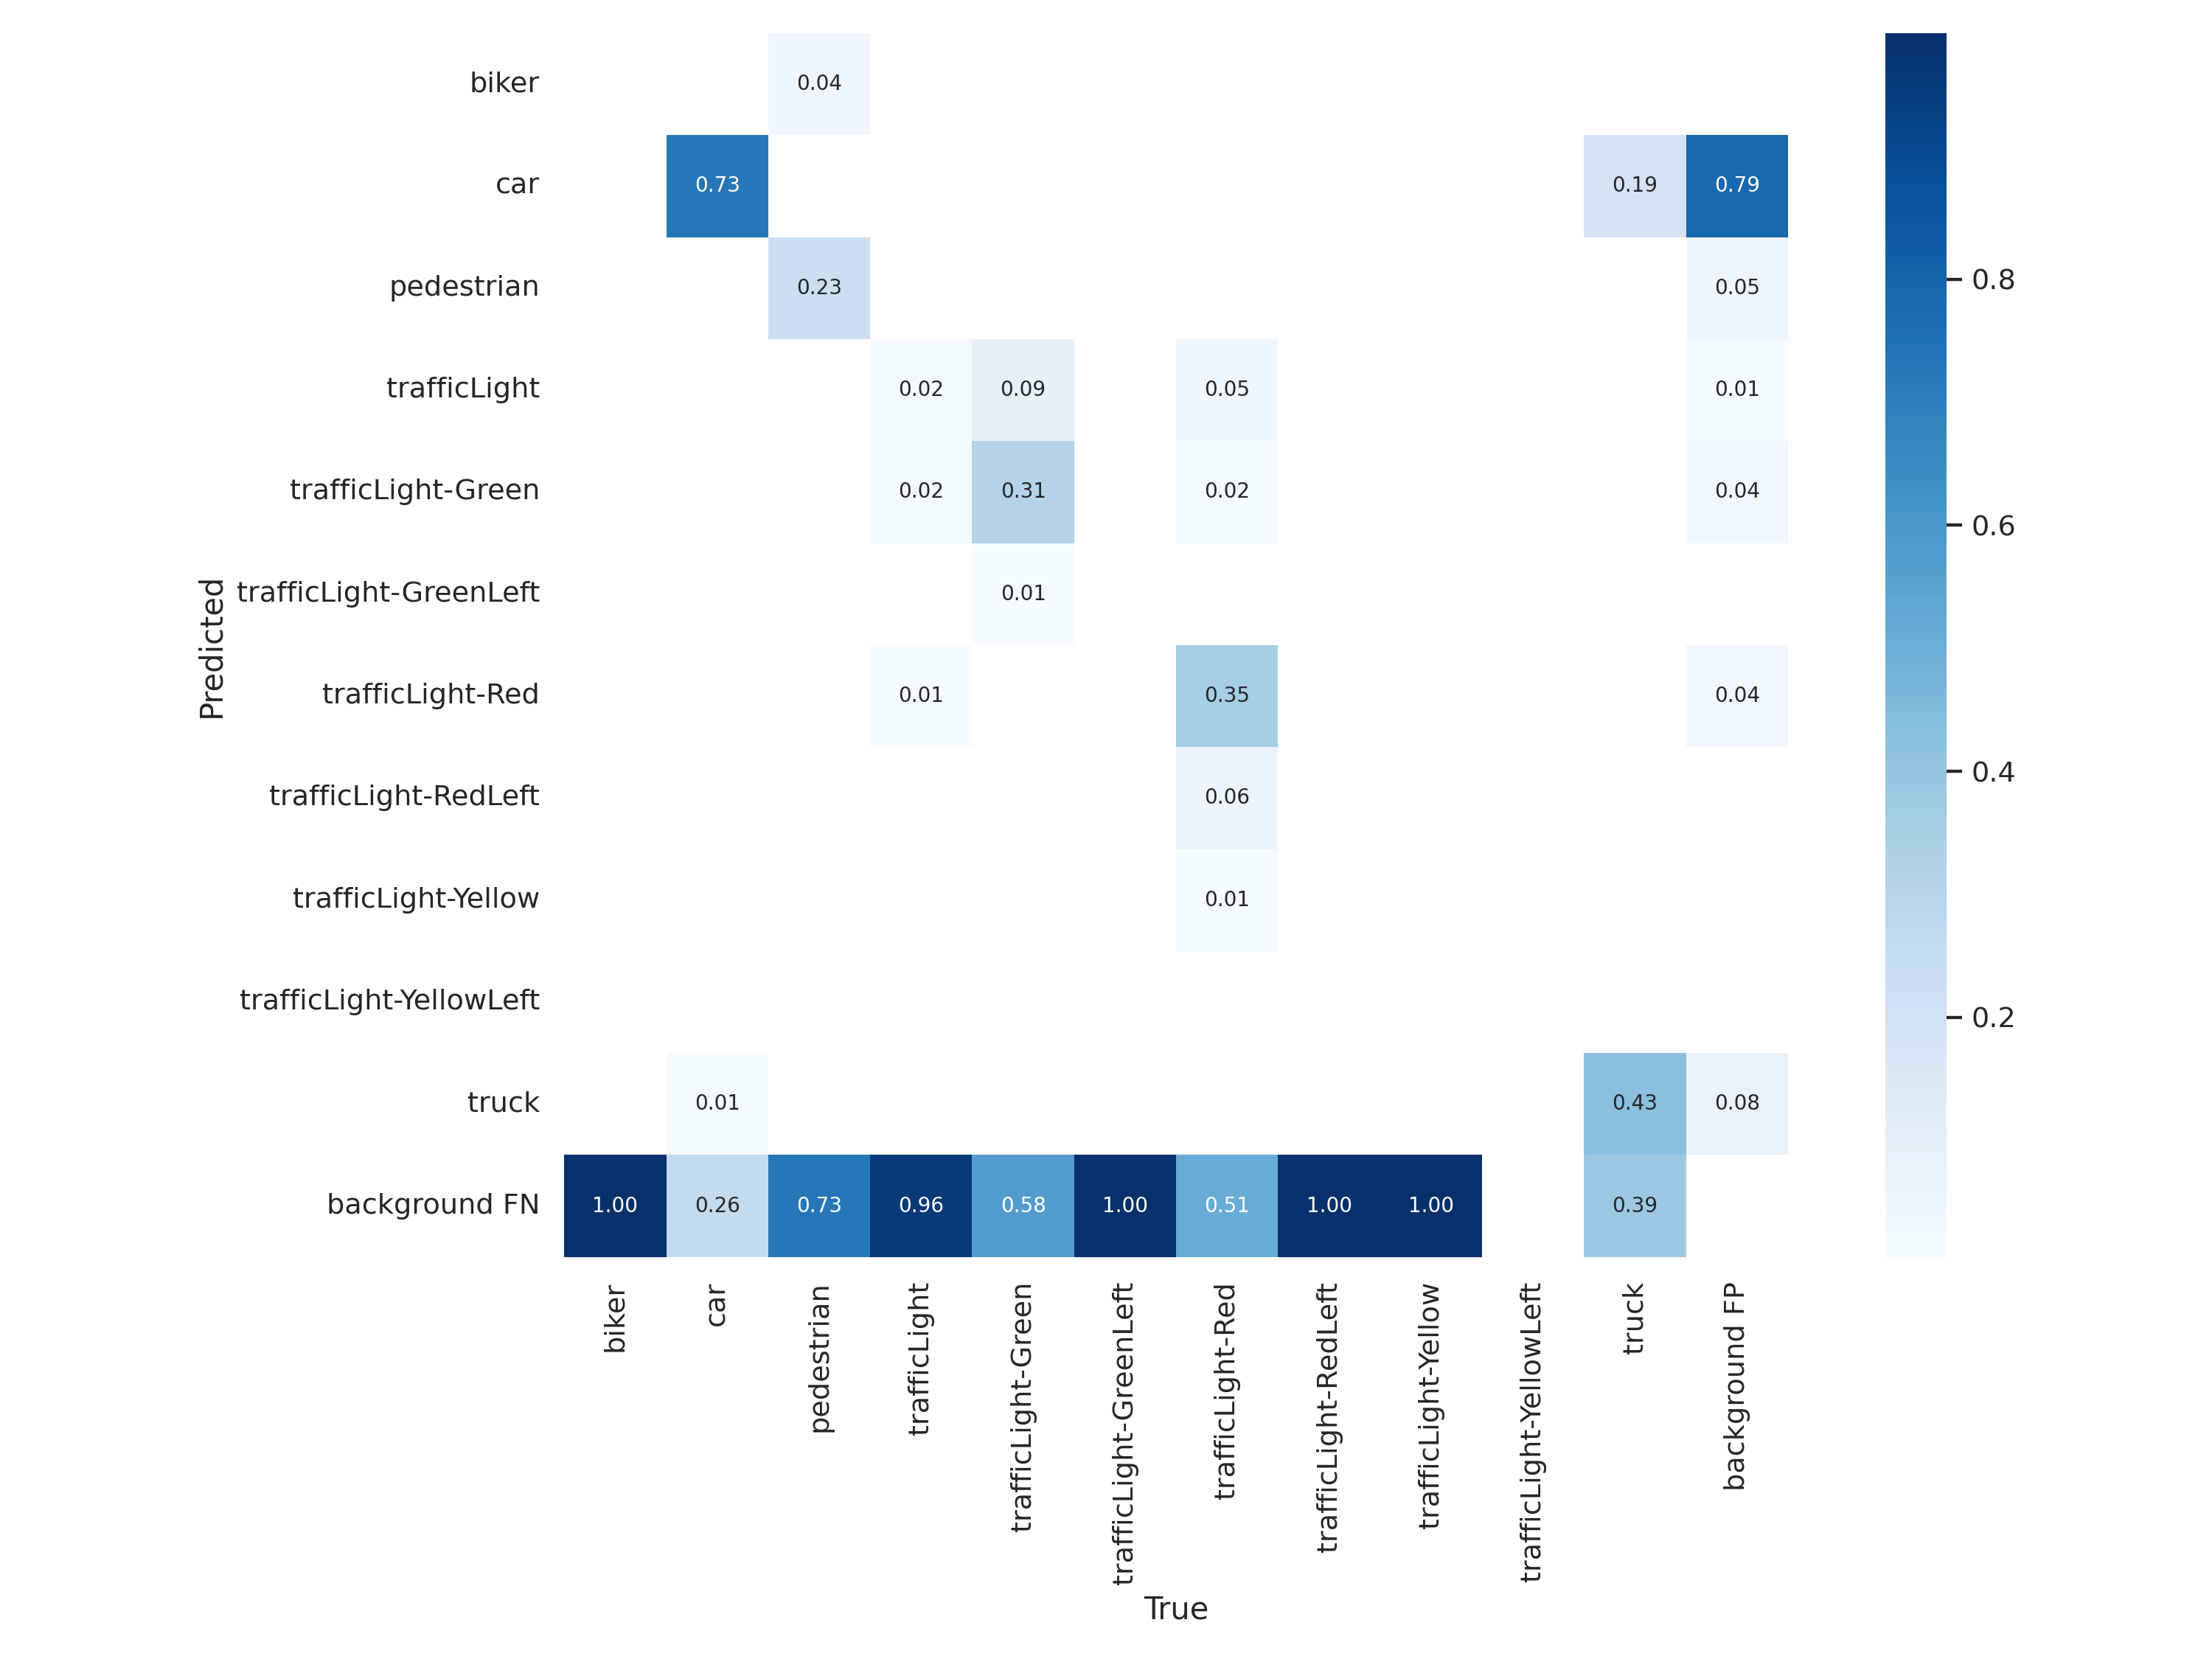


--- F1 Curve (car-vision-yolov7-finetune) ---


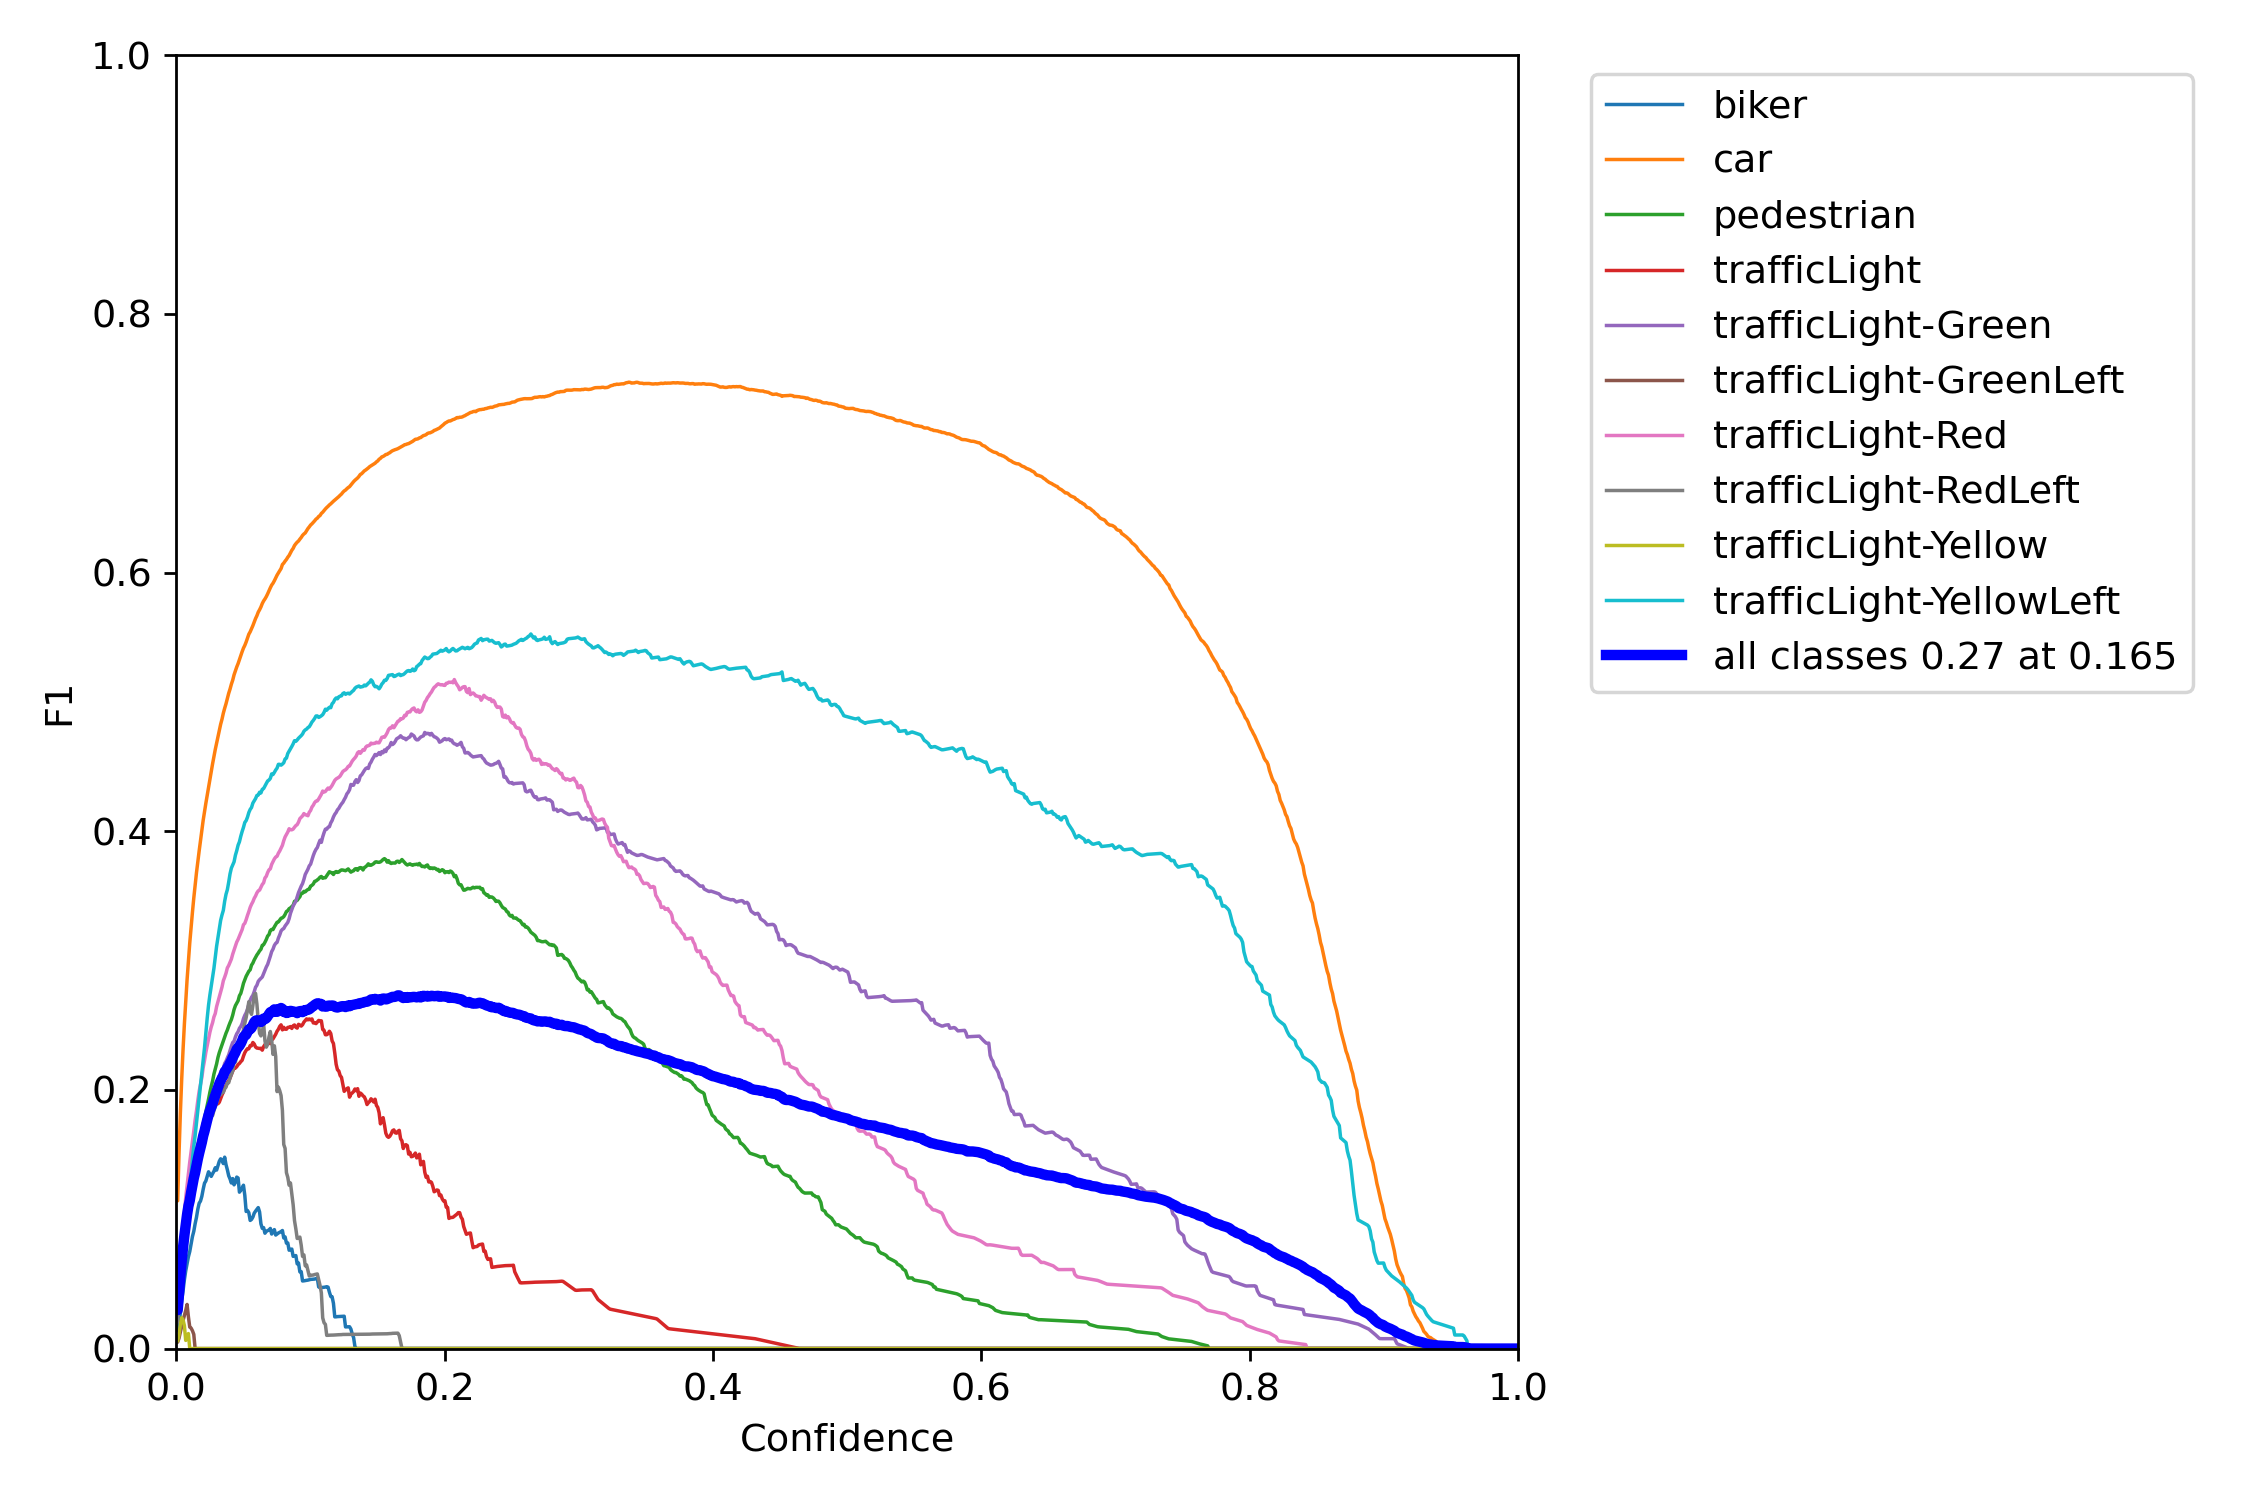

In [ ]:
# evaluate the model
#   Show metrics (mAP, precision/recall) if available.
#   Show loss curve or final results.

import os
from IPython.display import Image, display

results_dir = os.path.join('/content/yolov7/runs/train', EXP_NAME)

# Display training metrics from results.txt
results_file = os.path.join(results_dir, 'results.txt')
if os.path.exists(results_file):
    print(f"\n--- Training Metrics ({EXP_NAME}) ---")
    with open(results_file, 'r') as f:
        print(f.read())
else:
    print(f"Results file not found: {results_file}")

# Display results plot (loss curves, mAP, etc.)
results_plot = os.path.join(results_dir, 'results.png')
if os.path.exists(results_plot):
    print(f"\n--- Training Results Plot ({EXP_NAME}) ---")
    display(Image(filename=results_plot, width=800))
else:
    print(f"Results plot not found: {results_plot}")

# Optionally, display confusion matrix and F1 curve if available
confusion_matrix_plot = os.path.join(results_dir, 'confusion_matrix.png')
if os.path.exists(confusion_matrix_plot):
    print(f"\n--- Confusion Matrix ({EXP_NAME}) ---")
    display(Image(filename=confusion_matrix_plot, width=800))

F1_curve_plot = os.path.join(results_dir, 'F1_curve.png')
if os.path.exists(F1_curve_plot):
    print(f"\n--- F1 Curve ({EXP_NAME}) ---")
    display(Image(filename=F1_curve_plot, width=800))

## Predicting the classification of traffic-objects on Validation data


### Objectives

*  Run the trained model on a few test images.
*  Display images with predicted boxes.



Image: 1478897914983365227_jpg.rf.YKObyzxbWy8Ea19X9B7y.jpg


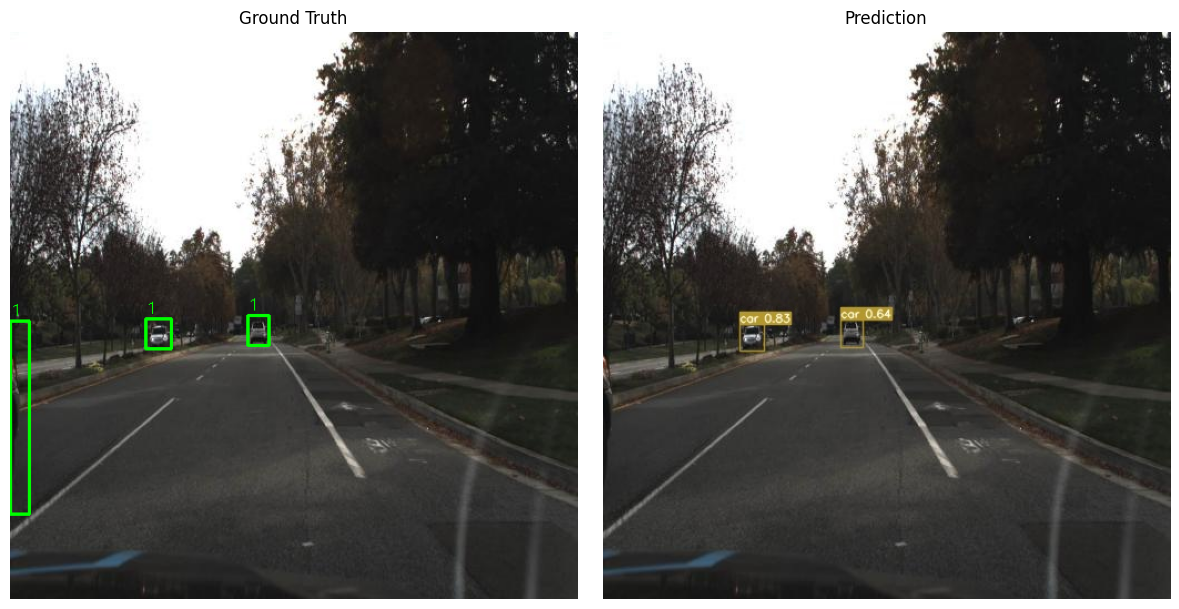


Image: 1478898368586708765_jpg.rf.sAk7i73HFL08ZBXJNk5T.jpg


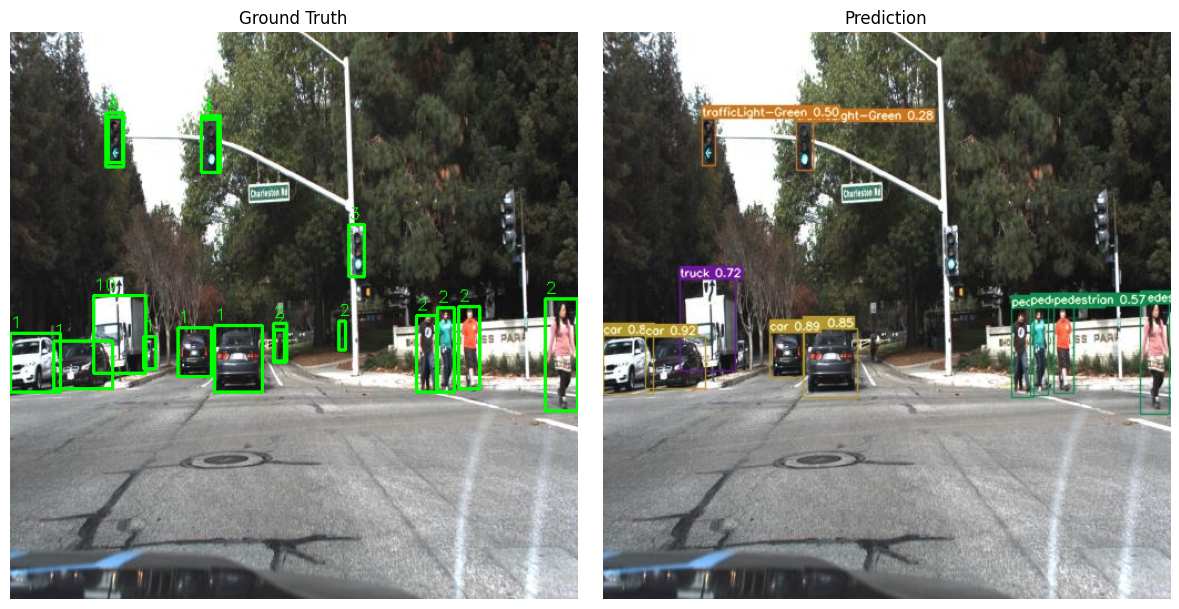


Image: 1478898657659698966_jpg.rf.4vdfFSo7zyusPxTe1xTr.jpg


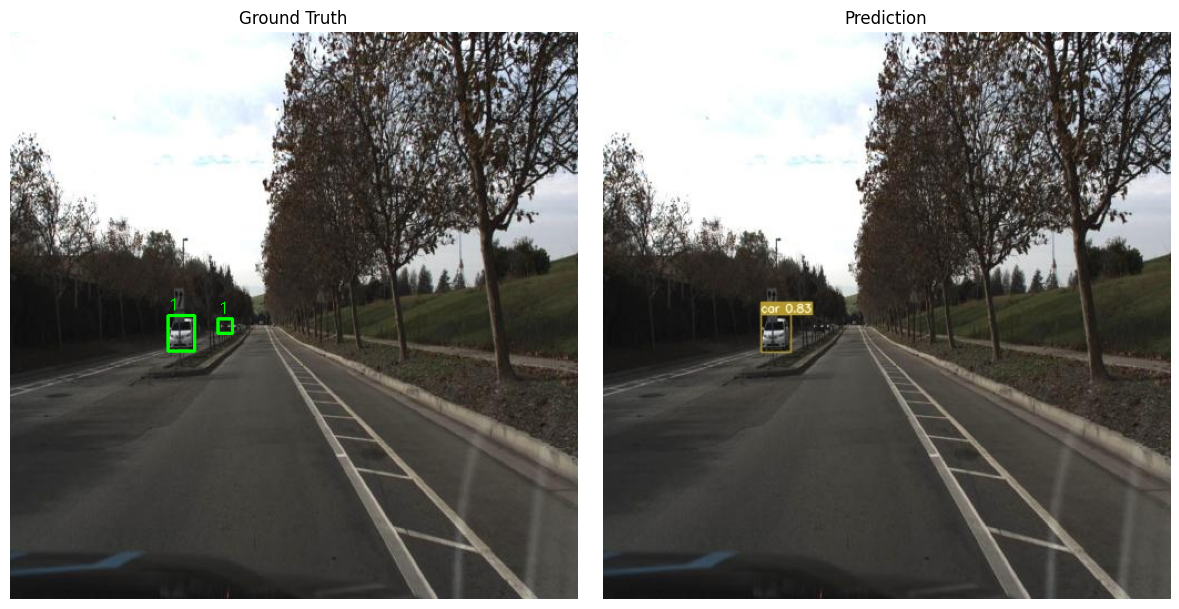


Image: 1478732799238372988_jpg.rf.4kkKlqztitrHm0VPBeE3.jpg


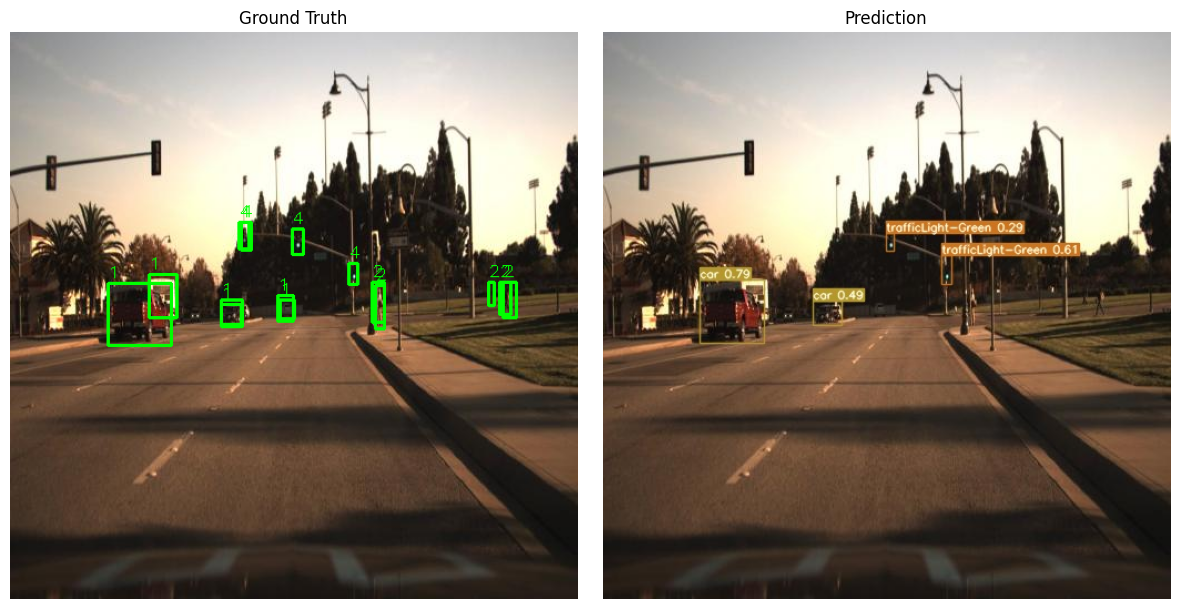


Image: 1478899554585155627_jpg.rf.79d2ab4392f63d2acc8a0b8e98736f6a.jpg


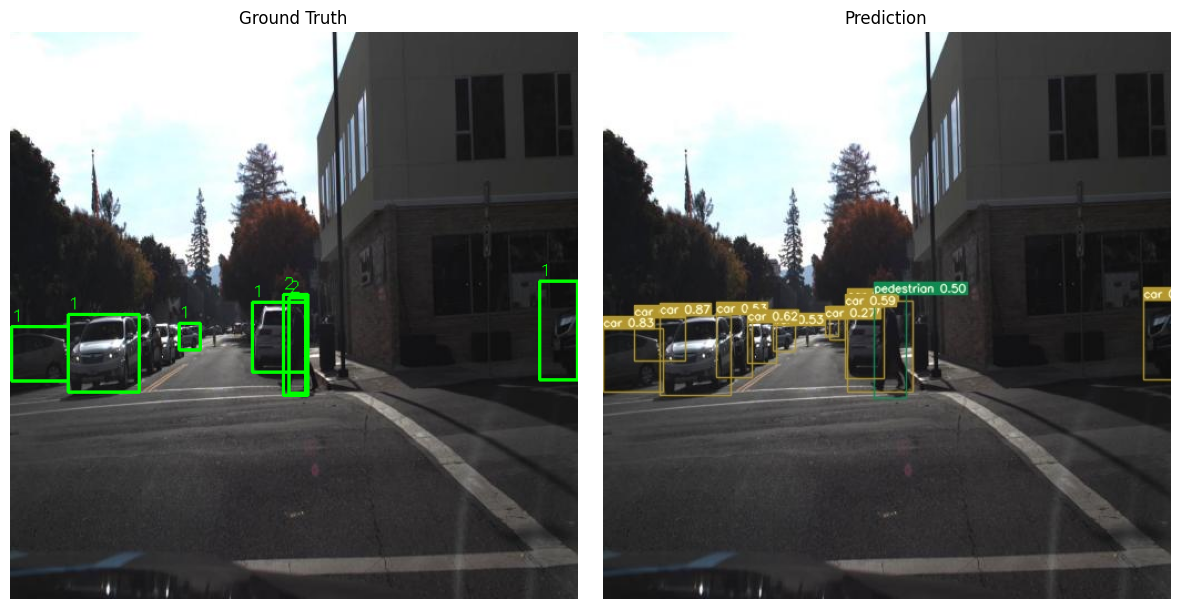

In [ ]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Sets up the paths for the validation images and labels along with a directory
# for the models predictions on the validation set.
valid_img_dir = Path("/content/data/yolov7/valid/images")
valid_lbl_dir = Path("/content/data/yolov7/valid/labels")
pred_dir      = Path(f"runs/detect/{EXP_NAME}-results")

# Collect all validation images
val_images = list(valid_img_dir.glob("*.jpg")) + list(valid_img_dir.glob("*.png"))

def load_yolo_labels(label_path: Path, img_w: int, img_h: int):
    """
    Load YOLO-format labels (class x_center y_center width height, all normalized)
    and convert them to pixel coordinates (x1, y1, x2, y2).
    """
    boxes = []
    if not label_path.exists():
        return boxes

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, x_c, y_c, w, h = map(float, parts)
            x_c *= img_w
            y_c *= img_h
            w   *= img_w
            h   *= img_h

            x1 = int(x_c - w / 2)
            y1 = int(y_c - h / 2)
            x2 = int(x_c + w / 2)
            y2 = int(y_c + h / 2)

            boxes.append((int(cls), x1, y1, x2, y2))
    return boxes

# Shows the predicted classification of the objects in the image as an integer
# Where the integer represents the specific classifcation of object. For example,
# a "10" above an object would mean that the model predicted that the object was
# a yellow, left arrow traffic light. On the right hand side is that actual
# classification of that same object in the image.
def show_pred_vs_gt(img_path: Path):
    # Original image
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Could not read image: {img_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    # Ground-truth boxes
    label_path = valid_lbl_dir / f"{img_path.stem}.txt"
    gt_boxes = load_yolo_labels(label_path, w, h)

    # Draw GT boxes on a copy
    gt_img = img_rgb.copy()
    for cls_id, x1, y1, x2, y2 in gt_boxes:
        cv2.rectangle(gt_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(gt_img, str(cls_id), (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Predicted image from detect.py (already has boxes drawn on it)
    pred_img_path = pred_dir / img_path.name
    if not pred_img_path.exists():
        print(f"No prediction image found for {img_path.name}, expected {pred_img_path}")
        return

    pred_img = cv2.imread(str(pred_img_path))
    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Show side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(gt_img)
    axs[0].set_title("Ground Truth")
    axs[0].axis("off")

    axs[1].imshow(pred_img)
    axs[1].set_title("Prediction")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

# Show a few random samples
num_samples = min(5, len(val_images))
for img_path in random.sample(val_images, num_samples):
    print(f"\nImage: {img_path.name}")
    show_pred_vs_gt(img_path)


### Experiment 2/3 - Evaluating on Smaller Training Data and Fewer Epochs


 (Epoch = 3, Image size 416)


In [ ]:
# Changing directory to YOLOv7
%cd /content/yolov7


EXP_NAME = "car-vision-img416-ep3"

# Runs the training model on a subset of the images, where the self_driving_data
# yaml contains the different classifications of objects (cars, traffic lights,
# pedestrians, etc.)
# The results of the experiment are assigned to the object EXP_name.

!python train.py \
  --img 416 \
  --batch 4 \
  --epochs 3 \
  --data /content/yolov7/self_driving_data.yaml \
  --cfg cfg/training/yolov7-tiny.yaml \
  --weights yolov7-tiny.pt \
  --name {EXP_NAME}


###A Brief Summary of the Two Experiments Training-Wise (Shenyi):
baseline training - experiment1 (epoch = 1) metric
- mAP@0.5 - 0.189
- mAP@0.5:0.95 - 0.083
- Precision - 0.464 (0.64 is the correct proportion)
- Recall - 0.262 (0.22 is the correct proportion)

experiment2 (epoch = 3) metric -- *Experiment 1 with (epoch = 3)*
- mAP@0.5 - 0.273 (0.25 is the correct proportion)
- mAP@0.5:0.95 - 0.123 (0.11 is the correct proportion)
- Precision - 0.572 (0.464 is the correct proportion)
- Recall - 0.324 (0.305 is the correct proportion)

Increasing epochs from 1 to 3 significantly improved all evalution metrics, which suggests that the model gets better at detecting the traffic objects in the images with more training iterations

# **Overall Evaluation of the Experiments (Bahaar)**

Across the two completed experiments, the trend is clear: increasing the number of training epochs substantially improves the model’s ability to detect objects in the self-driving dataset. The jump from 1 to 3 epochs produced noticeable gains across all metrics, particularly in precision and recall. This indicates that YOLOv7-Tiny is beginning to learn meaningful representations of the classes, but is still in the early stages of convergence.

Qualitative inspection of validation predictions also supports the numeric results. The model handles larger, more distinct objects (cars, trucks, cyclists) with growing confidence, while smaller objects such as traffic lights and pedestrians remain harder to localize consistently. This is expected given their small pixel footprint and the limited training time. Additionally, cars and people tend to be over-predicted as their classes account for over 75% of the 97,942 labels in the dataset.

Overall, the experiments demonstrate the model’s potential but also confirm that much more training is required before it reaches stable performance.

# **Conclusion**

These initial experiments show that YOLOv7-Tiny can begin to learn the structure of the dataset even with minimal training. The noticeable improvements from Experiment 1 to Experiment 2 illustrate how sensitive detection performance is to training duration. While the current accuracy levels are far from production-ready, the results provide a strong foundation for continued development.

Importantly, the steady upward trend in mAP, precision, and recall suggests that extending training to a realistic range (e.g., 50–100 epochs) would likely produce significant gains. The findings confirm that the chosen architecture is capable of adapting to the complexity of self-driving data, provided that it is trained sufficiently.

# **Limitations**

1. Very short training duration.
Training for only 1–3 epochs severely limits the model’s ability to converge.

2. Small batch size (4).
Leads to noisy gradients and slower improvements.

3. Resolution fixed at 512×512.
Small objects still remain difficult to detect, and Experiment 3 (416×416) did not run due to path issues.

4. Potential class imbalance.
Traffic-light subclasses may have significantly fewer examples compared to cars, trucks, and pedestrians.

5. Lack of detailed evaluation plots.
Loss curves, per-class AP, and confusion matrices would provide deeper insight but were not generated in this iteration.

6. No hyperparameter tuning.
Default settings were used; tuning could dramatically shift performance.